In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy
import datetime

# для расчетов над tdb
from pycalphad import Database, equilibrium, variables as v, binplot

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import pytensor
import pytensor.tensor as pt
# import theano
# theano.config.exception_verbosity = 'high' # должно выдавать подробное описание ошибки, но не помогает

import aesara

import seaborn as sns

# пути к tdb
cc10_path = "tdbs/CoCr-01Oik_with_new_functions.tdb"

print(f"Running on PyMC v{pm.__version__}") # 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.1
Running on NumPy v1.22.1
Running on ArviZ v0.15.1


# Функции и данные

In [33]:
def from_xarray_to_pandas(xarray_data, component_str, goal_phase_str):

    import numpy as np
    
    cr_tuple = xarray_data.X.sel(component=component_str).data[0][0]
    phase_tuple = xarray_data.Phase.data[0][0]
    t_tuple = xarray_data.T.data

    df = pd.DataFrame()

    # создали таблицу со всеми данными
    for i in range(phase_tuple.shape[2]):
        df_temp = pd.DataFrame(columns=['T','num','phase','conc'])
        df_temp['T'] = t_tuple
        df_temp['phase'] = phase_tuple[:, 0, i]
        df_temp['conc'] = cr_tuple[:, 0, i]
        
        df = pd.concat([df, df_temp])

    # смерджили нужные нам данные с имеющимися температурами
    df_res = pd.DataFrame({'T': t_tuple})
    df_res = pd.merge(df_res['T']
                    , df[(df['phase'] == goal_phase_str)][['T','phase','conc']]
                    , how = 'left'
                    , left_on = 'T'
                    , right_on = 'T')

    # заменили NaN значения
    df_res['phase'].fillna(goal_phase_str, inplace=True)
    df_res['conc'].fillna(10, inplace=True)

    return df_res


In [4]:
df_sigma_fcc = pd.read_excel('emp_data/sigma_fcc_allibert.xls')
# df_sigma_bcc = pd.read_excel('emp_data/sigma_bcc_allibert.xls')
df_sigma_hcp = pd.read_excel('emp_data/sigma_hcp_allibert.xls')

df_sigma_fcc = pd.concat([df_sigma_fcc, df_sigma_hcp])

df_sigma_fcc['T'] = df_sigma_fcc['T'].round(2)
df_sigma_fcc['cr_conc'] = df_sigma_fcc['cr_conc'].round(6)
df_sigma_fcc_sigma_old = df_sigma_fcc[(df_sigma_fcc['phase'] == 'sigma_old')].reset_index()
df_sigma_fcc_sigma_old

,index,cr_conc,T,phase
0,6,0.532019,1321.35,sigma_old
1,7,0.542469,1226.97,sigma_old
2,8,0.547749,1471.91,sigma_old
3,9,0.554050,1370.79,sigma_old
4,10,0.556156,1269.66,sigma_old
5,11,0.559283,1422.47,sigma_old
6,7,0.541762,928.09,sigma_old
7,8,0.545313,1020.22,sigma_old
8,9,0.551960,1069.66,sigma_old
9,10,0.558231,973.03,sigma_old


In [8]:
db10 = Database(cc10_path)

press = 101325
elements = ['CR', 'CO', 'VA']
el_cnt = 1

df_sigma_fcc_sigma_old = df_sigma_fcc_sigma_old.sort_values('T')

T = df_sigma_fcc_sigma_old['T'].to_numpy()
phase = 'SIGMA_OLD'

y_obs = df_sigma_fcc_sigma_old['cr_conc'].values
conditions = {v.X('CR'):0.5, v.P: 101325, v.T: T, v.N: el_cnt}
parameters_list = ['SIGMA_OLD_COCRCO_0', 'SIGMA_OLD_COCRCO_1', 'SIGMA_OLD_COCRCR_0', 'SIGMA_OLD_COCRCR_1']
component = 'CR'

print('T', T)
print('y_obs', y_obs)
# print('phases', phases)
print('phase', phase)

T [ 928.09  973.03 1020.22 1069.66 1121.35 1168.54 1217.98 1226.97 1269.66
 1321.35 1370.79 1422.47 1471.91]
y_obs [0.541762 0.558231 0.545313 0.55196  0.559991 0.565255 0.560713 0.542469
 0.556156 0.532019 0.55405  0.559283 0.547749]
phase SIGMA_OLD


# Class

In [58]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):
#     определяем тип входящих и исходящих данных
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.fvector]  # outputs a single scalar value (the log likelihood)

    def __init__(self, db, conditions, phase, elements, component, parameters_list):
        self.db_tdb = db
        self.conditions_dict = conditions
        self.phases_list = list(self.db_tdb.phases.keys())
        self.phase_str = phase
        self.elements_list = elements
        self.component_str = component
        self.parameters_list = parameters_list
        
        self.y_eqs = []
        self.likelihoods = []

    def perform(self, node, inputs, outputs):
        
        (theta,) = inputs  # this will contain my variables
        
        # новая версия
        new_parameters = dict()
        
        for i in range(len(self.parameters_list)):
            new_parameters[self.parameters_list[i]] = inputs[0][i]

        
        # старая версия
        # COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1 = theta

        # new_parameters = {
        #  'SIGMA_OLD_COCRCO_0' : COCRCO_0
        #  ,'SIGMA_OLD_COCRCO_1': COCRCO_1
        #  ,'SIGMA_OLD_COCRCR_0': COCRCR_0
        #  ,'SIGMA_OLD_COCRCR_1': COCRCR_1
        # }
        # print(new_parameters)
        
        
        y_eq = (from_xarray_to_pandas(equilibrium(self.db_tdb
                                            , self.elements_list
                                            , self.phases_list
                                            , self.conditions_dict
                                            , parameters = new_parameters
                                        ), self.component_str, self.phase_str)['conc']
                .astype(np.float32)
                .to_numpy())

        outputs[0][0] = y_eq
                             
                             

# Model

In [59]:
pytensor.config.exception_verbosity = 'high' 

test_model = pm.Model()

logl = LogLike(db10, conditions, phase, elements, component, parameters_list)

with test_model:
    # uniform priors on m and c
    COCRCO_0 = pm.Normal("SIGMA_OLD_COCRCO_0", mu=-103863.0, sigma=1)
    COCRCO_1 = pm.Normal("SIGMA_OLD_COCRCO_1", mu=47.47, sigma=1)
    COCRCR_0 = pm.Normal("SIGMA_OLD_COCRCR_0", mu=-248108.8, sigma=1)
    COCRCR_1 = pm.Normal("SIGMA_OLD_COCRCR_1", mu=79.12, sigma=1) 
    


    # theta = [COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1]
    theta = pt.as_tensor_variable([COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1])
    # theta_2 = np.array([COCRCO_0, COCRCO_1, COCRCR_0, COCRCR_1])
    
    # likelihood = pm.DensityDist("likelihood", logp = logl_2, observed=y_obs)
    
    # likelihood_2 = pm.Potential("likelihood", logl(theta))
    # pm.HalfNormal("obs", logl(theta), observed=y_obs)#, 
    y_det = pm.Deterministic("y_det", logl(theta))
    y_norm = pm.Normal("y_norm", mu=y_det, sigma = 0.001, observed=y_obs)
    trace = pm.sample(5, tune=5)
    # idata = pm.sample_prior_predictive(samples=5)

    
    # trace = pm.sample(draws=2000, tune=500, idata_kwargs={"log_likelihood": True}, progressbar=True)

Only 5 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [SIGMA_OLD_COCRCO_0]
>Slice: [SIGMA_OLD_COCRCO_1]
>Slice: [SIGMA_OLD_COCRCR_0]
>Slice: [SIGMA_OLD_COCRCR_1]


Sampling 4 chains for 5 tune and 5 draw iterations (20 + 20 draws total) took 63 seconds.
The number of samples is too small to check convergence reliably.


In [ ]:
trace.to_json('calc_res/trace_cocr_500x2000x4.json')

In [60]:
logl(theta).eval()

array([0.53575313, 0.5358131 , 0.5361049 , 0.5366508 , 0.5374767 ,
       0.53845716, 0.53971994, 0.5399761 , 0.54130846, 0.54755723,
       0.55415404, 0.56082404, 0.56703216], dtype=float32)

In [61]:
pm.draw(COCRCO_0).item()

-103863.12229660562

In [62]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [63]:
az.summary(trace.posterior)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
SIGMA_OLD_COCRCO_0,-103862.675,0.977,-103864.284,-103861.267,0.223,0.160,19.0,19.0,1.74
SIGMA_OLD_COCRCO_1,52.062,1.071,50.925,53.850,0.244,0.175,19.0,19.0,2.53
SIGMA_OLD_COCRCR_0,-248108.441,0.993,-248109.785,-248106.416,0.226,0.163,19.0,16.0,0.92
SIGMA_OLD_COCRCR_1,78.946,1.338,76.743,80.234,0.305,0.219,19.0,19.0,4.78
y_det[0],0.544,0.000,0.543,0.545,0.000,0.000,19.0,16.0,1.63
y_det[1],0.544,0.000,0.544,0.545,0.000,0.000,19.0,16.0,1.61
y_det[2],0.545,0.000,0.544,0.545,0.000,0.000,19.0,16.0,1.25
y_det[3],0.545,0.000,0.545,0.546,0.000,0.000,19.0,16.0,1.07
y_det[4],0.546,0.000,0.546,0.547,0.000,0.000,19.0,16.0,1.11
y_det[5],0.548,0.000,0.547,0.548,0.000,0.000,19.0,19.0,0.90


In [64]:
with test_model:
    ppc = pm.sample_posterior_predictive(trace)

In [79]:
ppc.posterior_predictive.variables['y_norm'][0][0]

<xarray.Variable (y_norm_dim_2: 13)>
array([0.54157191, 0.54401469, 0.54519865, 0.54631228, 0.54682792,
       0.54694432, 0.54768105, 0.54950403, 0.55187778, 0.55544135,
       0.5628104 , 0.56760133, 0.57347348])

<Axes: xlabel='y_norm / y_norm'>

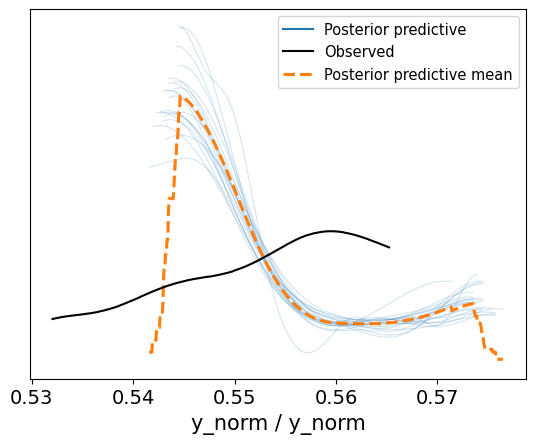

In [65]:
az.plot_ppc(ppc)